# Vehicle Loan Prediction Machine Learning Model

# 3. Feature Engineering

### Import Libraries and Import Data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import warnings
from sklearn.preprocessing import MinMaxScaler

In [ ]:
# Suppress warniing to avoid clutter in the output
warnings.filterwarnings("ignore")

In [2]:
# Load data
loan_df = pd.read_csv('../data/vehicle_loans_eda.csv', index_col='UNIQUEID')

In [3]:
# Get loan_df head
loan_df.head()

DISBURSED_AMOUNT  ASSET_COST    LTV  MANUFACTURER_ID  \
UNIQUEID                                                         
420825               50578       58400  89.55               45   
537409               47145       65550  73.23               45   
417566               53278       61360  89.63               45   
624493               57513       66113  88.48               45   
539055               52378       60300  88.39               45   

         EMPLOYMENT_TYPE  STATE_ID  AADHAR_FLAG  PAN_FLAG  VOTERID_FLAG  \
UNIQUEID                                                                  
420825          Salaried         6            1         0             0   
537409     Self employed         6            1         0             0   
417566     Self employed         6            1         0             0   
624493     Self employed         6            1         0             0   
539055     Self employed         6            1         0             0   

          DRIVING_FLAG  ...  PRIMARY_INSTAL_AMT  SEC_INSTAL_AMT  \
UNIQUEID                ...                                       
420825               0  ...                   0               0   
537409               0  ...                1991               0   
417566               0  ...                   0               0   
624493               0  ...                  31               0   
539055               0  ...                   0               0   

         NEW_ACCTS_IN_LAST_SIX_MONTHS  DELINQUENT_ACCTS_IN_LAST_SIX_MONTHS  \
UNIQUEID                                                                     
420825                              0                                    0   
537409                              0                                    1   
417566                              0                                    0   
624493                              0                                    0   
539055                              0                                    0   

          NO_OF_INQUIRIES  LOAN_DEFAULT  AGE  DISBURSAL_MONTH  \
UNIQUEID                                                        
420825                  0             0   34                3   
537409                  0             1   33                9   
417566                  0             0   32                1   
624493                  1             1   24               10   
539055                  1             1   41                9   

          AVERAGE_ACCT_AGE_MONTHS  CREDIT_HISTORY_LENGTH_MONTHS  
UNIQUEID                                                         
420825                          0                             0  
537409                         23                            23  
417566                          0                             0  
624493                          8                            15  
539055                          0                             0  

[5 rows x 35 columns]

Let’s bring in the explore_categorical and explore_continuous functions we created

In [4]:
def explore_categorical(col_name):   
    print("{0} Summary".format(col_name))
    print("\n")
    
    # Print the count of each category
    print("{0} Counts".format(col_name))
    print(loan_df[col_name].value_counts())
    print("\n")

    # Print the ratio of each category
    print("{0} Ratio".format(col_name))
    print(loan_df[col_name].value_counts(normalize=True))
    print("\n")
    
    # Print counts of loan defaults grouped by the categorical column
    print("{0} Default Counts".format(col_name))
    print(loan_df.groupby(col_name)['LOAN_DEFAULT'].value_counts().unstack(level=-1))
    print("\n")

    # Print ratio of loan defaults grouped by the categorical column
    print("{0} Default Ratio".format(col_name))
    print(loan_df.groupby(col_name)['LOAN_DEFAULT'].value_counts(normalize=True).unstack(level=-1))
    print("\n")

    # Plot ratio of loan defaults by the categorical column
    sns.catplot(data=loan_df,kind='count',x=col_name,hue='LOAN_DEFAULT')
    plt.show()

In [5]:
def explore_continuous(col_name):
    # Print statistical summary
    print("{0} Summary".format(col_name))
    print("\n")
    print(loan_df[col_name].describe())
    print("\n")

    # Look at boxplot
    sns.boxplot(x=col_name, data=loan_df)
    plt.show()

    # Look at the distribution
    sns.distplot(loan_df[col_name], hist=False)
    plt.show()

    # Now lets look deeper by grouping with the target variable 
    print("{0} Grouped Summary".format(col_name))
    print("\n")
    print(loan_df.groupby('LOAN_DEFAULT')[col_name].describe())

    # Look at grouped boxplot 
    sns.boxplot(x=col_name, y='LOAN_DEFAULT', data=loan_df, orient="h")
    plt.show()

## Binning

In our exploratory analysis, we observed that disbursed amount had some extremely large values?

Let's take another look at that with our explore_continuous function

DISBURSED_AMOUNT Summary


count    233154.000000
mean      54356.993528
std       12971.314171
min       13320.000000
25%       47145.000000
50%       53803.000000
75%       60413.000000
max      990572.000000
Name: DISBURSED_AMOUNT, dtype: float64




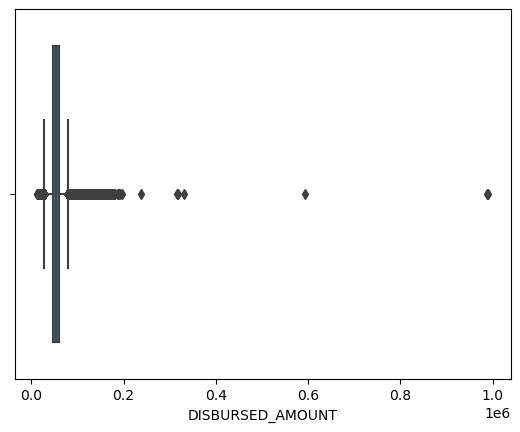

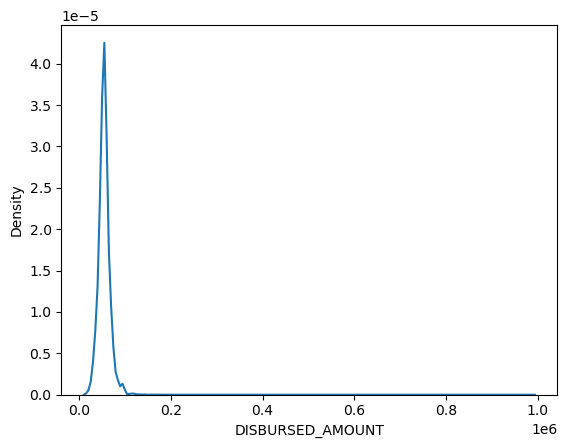

DISBURSED_AMOUNT Grouped Summary


                 count          mean           std      min      25%      50%  \
LOAN_DEFAULT                                                                    
0             182543.0  53826.471111  13140.699007  13320.0  46369.0  53303.0   
1              50611.0  56270.473869  12150.255527  13369.0  49303.0  55459.0   

                  75%       max  
LOAN_DEFAULT                     
0             59947.0  990572.0  
1             61947.0  191392.0  


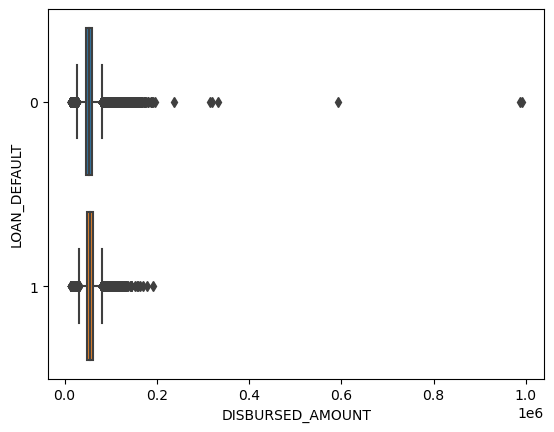

In [6]:
# Analyse 'DISBURSED_AMOUNT'
explore_continuous('DISBURSED_AMOUNT')

Notice that the largest value here is 990,572 this is considerably larger than the next largest value which is also an extreme outlier 

Is it possible that this could be an error in the data?
- If we assume that the disbursal amount is stored in Indian rupees then 990,572 equates to ~ £10,000 or $13,400
- Indeed a lot of money but not impossible for a car loan 

Let's check the row data, LTV and ASSET_COST should give us an idea about whether or not this is a valid piece of data 

In [7]:
loan_df['DISBURSED_AMOUNT'].idxmax()

440173

In [8]:
loan_df.loc[loan_df['DISBURSED_AMOUNT'].idxmax()]

DISBURSED_AMOUNT                                                                  990572
ASSET_COST                                                                       1628992
LTV                                                                                61.39
MANUFACTURER_ID                                                                      152
EMPLOYMENT_TYPE                                                                  Missing
STATE_ID                                                                               9
AADHAR_FLAG                                                                            1
PAN_FLAG                                                                               1
VOTERID_FLAG                                                                           0
DRIVING_FLAG                                                                           0
PASSPORT_FLAG                                                                          0
PERFORM_CNS_SCORE    

It seems reasonable that the applicant borrowed 990,572 to pay for a car that cost 1,628,992. Let's assume a legitimate value that we want to include in our model 

One way we can keep extreme values without them skewing the data is through binning
- Creating categorical groups from continuous variables


In [9]:
# Define bins and labels for categorising 'DISBURSED_AMOUNT'
disbursed_buckets = [13000, 30000, 45000, 60000, 75000, 150000, 1000000]
disbursed_labels = ['13k - 30k', '30k - 45k', '45k - 60k', '60k - 75k', '75k - 150k', '150k - 1m']

Now we need to use these bins to categorize our rows based on their disbursed amounts

In [10]:
# Define a new categorical column based on 'DISBURSED_AMOUNT'
loan_df['DISBURSED_CAT'] = pd.cut(loan_df['DISBURSED_AMOUNT'], disbursed_buckets, labels=disbursed_labels)

Let's use explore_categorical to take a look at our new column!

DISBURSED_CAT Summary


DISBURSED_CAT Counts
DISBURSED_CAT
45k - 60k     126904
60k - 75k      49824
30k - 45k      40626
75k - 150k     10871
13k - 30k       4865
150k - 1m         64
Name: count, dtype: int64


DISBURSED_CAT Ratio
DISBURSED_CAT
45k - 60k     0.544293
60k - 75k     0.213696
30k - 45k     0.174245
75k - 150k    0.046626
13k - 30k     0.020866
150k - 1m     0.000274
Name: proportion, dtype: float64


DISBURSED_CAT Default Counts
LOAN_DEFAULT       0      1
DISBURSED_CAT              
13k - 30k       4207    658
30k - 45k      34323   6303
45k - 60k      98830  28074
60k - 75k      37056  12768
75k - 150k      8070   2801
150k - 1m         57      7


DISBURSED_CAT Default Ratio
LOAN_DEFAULT          0         1
DISBURSED_CAT                    
13k - 30k      0.864748  0.135252
30k - 45k      0.844853  0.155147
45k - 60k      0.778778  0.221222
60k - 75k      0.743738  0.256262
75k - 150k     0.742342  0.257658
150k - 1m      0.890625  0.109375




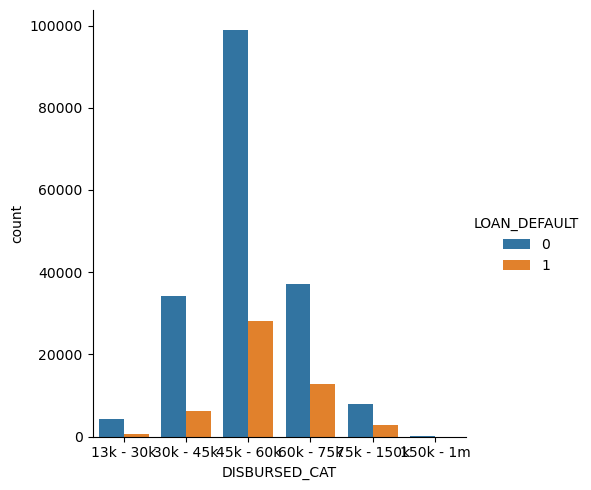

In [11]:
# Use the explore_categorical function to analyse the new 'DISBURSED_CAT' column
explore_categorical('DISBURSED_CAT')

Notice that the vast majority of loans fall in the '45k - 60k' bucket. 

Also, the higher the loan amount, the more likely it was to default except for loans in the very largest category

## Combine Features

### Disbursal Difference

In [12]:
# Create a new feature 'DISBURSAL_DIFFERENCE'
loan_df['DISBURSAL_DIFFERENCE'] = loan_df['ASSET_COST'] - loan_df['DISBURSED_AMOUNT']

Let's inspect our new column

In [13]:
# Display a sample of the new feature
loan_df[['DISBURSAL_DIFFERENCE', 'ASSET_COST', 'DISBURSED_AMOUNT']].sample(5)

DISBURSAL_DIFFERENCE  ASSET_COST  DISBURSED_AMOUNT
UNIQUEID                                                    
581232                   12146       58395             46249
464386                   33647       93655             60008
558638                   21640       73718             52078
537184                   42456       75140             32684
514335                   19333       66478             47145

### Primary and Secondary Account Engineering

The loan data contains 14 columns providing information about any existing loans a customer may have. This data is split according to primary and secondary accounts, a primary account is a loan where the customer is the sole recipient of the disbursal, 
a secondary account is one where the customer is a co-applicant or guarantor for the loan 

- PRI_NO_OF_ACCTS: count of total loans taken by the customer at the time of disbursement  
- PRI_ACTIVE_ACCTS: count of active loans taken by the customer at the time of disbursement
- PRI_OVERDUE_ACCTS: count of default accounts at the time of disbursement    
- PRI_CURRENT_BALANCE: total Principal outstanding amount of the active loans at the time of disbursement        
- PRI_SANCTIONED_AMOUNT: total amount that was sanctioned for all the loans at the time of disbursement  
- PRI_DISBURSED_AMOUNT: total amount that was disbursed for all the loans at the time of disbursement
- PRIMARY_INSTAL_AMT: EMI Amount of the primary loan
- SEC_NO_OF_ACCTS: count of secondary total loans taken by the customer at the time of disbursement 
- SEC_ACTIVE_ACCTS: count of secondary active loans taken by the customer at the time of disbursement 
- SEC_OVERDUE_ACCTS: count of secondary accounts at the time of disbursement    
- SEC_CURRENT_BALANCE: total Principal outstanding amount of the secondary active loans at the time of disbursement 
- SEC_SANCTIONED_AMOUNT: total amount that was sanctioned for all the secondary loans at the time of disbursement  
- SEC_DISBURSED_AMOUNT: total amount that was disbursed for all the secondary loans at the time of disbursement
- SEC_INSTAL_AMT: EMI Amount of the secondary loan 

Hopefully, you will see that in the majority of cases the data in these columns is limited

Instead of simply dropping them, we will combine so we can reduce the complexity of our data without losing information

For example, we can create a column 'TOTAL_ACCTS' to store the combined total of primary and secondary accounts


In [14]:
# Combine primary and secondary account features
loan_df['TOTAL_ACCTS'] = loan_df['PRI_NO_OF_ACCTS'] + loan_df['SEC_NO_OF_ACCTS']

Let's look at the results

In [15]:
# Display a sample of the results
loan_df[['TOTAL_ACCTS', 'PRI_NO_OF_ACCTS', 'SEC_NO_OF_ACCTS']].sample(10)

TOTAL_ACCTS  PRI_NO_OF_ACCTS  SEC_NO_OF_ACCTS
UNIQUEID                                               
626954              0                0                0
513515              5                5                0
558983              0                0                0
475951              0                0                0
435783              0                0                0
552804              0                0                0
612444              0                0                0
485300              2                1                1
565261              1                1                0
630066             15               15                0

In [16]:
# Combine primary and secondary account features into aggregated columns
loan_df['TOTAL_ACTIVE_ACCTS'] = loan_df['PRI_ACTIVE_ACCTS'] + loan_df['SEC_ACTIVE_ACCTS']
loan_df['TOTAL_OVERDUE_ACCTS'] = loan_df['PRI_OVERDUE_ACCTS'] + loan_df['SEC_OVERDUE_ACCTS']
loan_df['TOTAL_CURRENT_BALANCE'] = loan_df['PRI_CURRENT_BALANCE'] + loan_df['SEC_CURRENT_BALANCE']
loan_df['TOTAL_SANCTIONED_AMOUNT'] = loan_df['PRI_SANCTIONED_AMOUNT'] + loan_df['SEC_SANCTIONED_AMOUNT'] 
loan_df['TOTAL_DISBURSED_AMOUNT'] = loan_df['PRI_DISBURSED_AMOUNT'] + loan_df['SEC_DISBURSED_AMOUNT']
loan_df['TOTAL_INSTAL_AMT'] = loan_df['PRIMARY_INSTAL_AMT'] + loan_df['SEC_INSTAL_AMT']

Now we have simplified our dataset by combining the primary and secondary account columns 

Let's drop the ones we no longer need to avoid data duplication

In [17]:
# Drop the old primary and secondary account columns to avoid redundancy
drop_cols = ['PRI_NO_OF_ACCTS', 'PRI_ACTIVE_ACCTS', 'PRI_OVERDUE_ACCTS', 'PRI_CURRENT_BALANCE', 'PRI_SANCTIONED_AMOUNT', 'PRI_DISBURSED_AMOUNT', 'PRIMARY_INSTAL_AMT', 'SEC_NO_OF_ACCTS', 'SEC_ACTIVE_ACCTS', 'SEC_OVERDUE_ACCTS', 'SEC_CURRENT_BALANCE', 'SEC_SANCTIONED_AMOUNT', 'SEC_DISBURSED_AMOUNT', 'SEC_INSTAL_AMT']
loan_df = loan_df.drop(drop_cols, axis=1)

We may also be interested in calculating the percentage of overdue accounts a person has

In [18]:
# Calculate the percentage of overdue accounts
loan_df['OVERDUE_PCT'] = loan_df['TOTAL_OVERDUE_ACCTS'] / loan_df['TOTAL_ACCTS']

Check this new column for missing values, remember a lot of rows will have 0 'TOTAL_ACCTS'

In [19]:
# Check column for missing values
loan_df['OVERDUE_PCT'].isnull().sum()

115792

Ok, we have a lot of missing values we can fill them with 0s using [fillna](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.fillna.html)

In [20]:
# Fill missing values with 0
loan_df['OVERDUE_PCT'] = loan_df['OVERDUE_PCT'].fillna(0)

Let's use [isnull](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.isnull.html) and [sum](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.sum.html) again to make sure we no longer have missing values

In [21]:
# Check for any remaining missing values
loan_df['OVERDUE_PCT'].isnull().sum()

0

Our new OVERDUE_PCT column no longer has any missing values. 

We have done a lot of feature engineering so far, so let's use the [info](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.info.html) function to take a look at our columns

In [22]:
# Get info on 'OVERDUE_PCT' column
loan_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 233154 entries, 420825 to 630213
Data columns (total 31 columns):
 #   Column                               Non-Null Count   Dtype   
---  ------                               --------------   -----   
 0   DISBURSED_AMOUNT                     233154 non-null  int64   
 1   ASSET_COST                           233154 non-null  int64   
 2   LTV                                  233154 non-null  float64 
 3   MANUFACTURER_ID                      233154 non-null  int64   
 4   EMPLOYMENT_TYPE                      233154 non-null  object  
 5   STATE_ID                             233154 non-null  int64   
 6   AADHAR_FLAG                          233154 non-null  int64   
 7   PAN_FLAG                             233154 non-null  int64   
 8   VOTERID_FLAG                         233154 non-null  int64   
 9   DRIVING_FLAG                         233154 non-null  int64   
 10  PASSPORT_FLAG                        233154 non-null  int64   
 11  

We have reduced our number of columns to 30

Also, notice the presence of our new columns at the bottom of the list.

## Scaling 

- We will use min max scaling to bring our continuous variables into the same range 
- Outliers have been observed in the data. However, we will keep them as they appear to be legitimate
- Sklearn provides an implementation of Min Max scaling, [MinMaxScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html)

First, we create a list of our continuous columns 
- We can use this list to select the continuous variables from our dataframe without typing a long list of column names each time 
- We don't need to scale our categoricals or binaries



In [23]:
# List of numeric columns to be scaled
numeric_cols = ['DISBURSED_AMOUNT', 
                'ASSET_COST', 
                'LTV', 
                'NEW_ACCTS_IN_LAST_SIX_MONTHS', 
                'DELINQUENT_ACCTS_IN_LAST_SIX_MONTHS', 
                'NO_OF_INQUIRIES', 
                'AGE', 
                'AVERAGE_ACCT_AGE_MONTHS', 
                'CREDIT_HISTORY_LENGTH_MONTHS',
                'PERFORM_CNS_SCORE',
                'TOTAL_ACCTS',
                'TOTAL_ACTIVE_ACCTS',
                'TOTAL_OVERDUE_ACCTS',
                'TOTAL_CURRENT_BALANCE', 
                'TOTAL_SANCTIONED_AMOUNT', 
                'TOTAL_DISBURSED_AMOUNT', 
                'TOTAL_INSTAL_AMT', 
                'OVERDUE_PCT', 
                'DISBURSAL_DIFFERENCE']

Let's look at the numeric columns so we have a reference. 

We can plot multiple columns on the same plot using pandas [boxplot](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.boxplot.html)

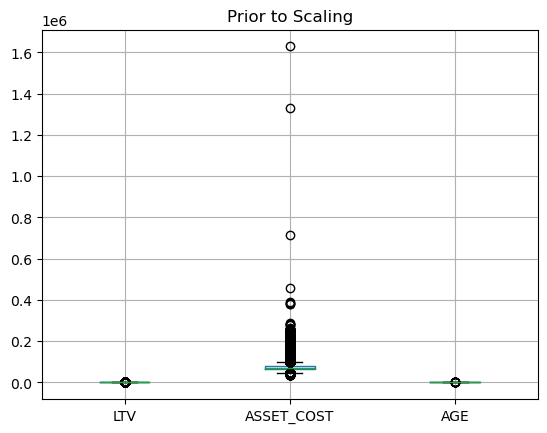

In [24]:
# Plot boxplots for a few numeric columns
loan_df[['LTV', 'ASSET_COST', 'AGE']].boxplot()
plt.title('Prior to Scaling')
plt.show()

Observe that the numeric values are distributed across very different scales.

Let's fix this problem using Min Max Scaling. 

First we need to create an instance of [MinMaxScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html) 

In [25]:
# Initialise the MinMaxScaler
mm_scaler = MinMaxScaler()

We can use [fit_transform](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html#sklearn.preprocessing.MinMaxScaler.fit_transform) to fit the scaler to our data and perform the scaling

In [26]:
# Apply MinMax scaling to the numeric columns
loan_df[numeric_cols] = mm_scaler.fit_transform(loan_df[numeric_cols])

Let's have a quick look at the boxplots now

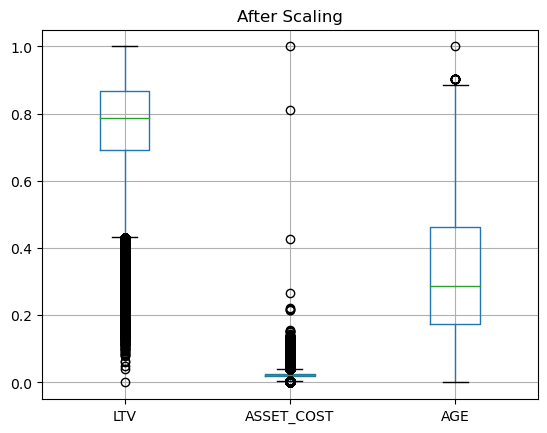

In [27]:
# Plot boxplots for the same numeric columns after scaling to check the normalisation
loan_df[['LTV', 'ASSET_COST', 'AGE']].boxplot()
plt.title('After Scaling')
plt.show()

Now all the values are ranged between 1 and 0

In [28]:
# loan_df.to_csv('../data/vehicle_loans_feat.csv')